In [ ]:
import os
import torch
import xarray as xr
import numpy as np
from torch.utils.data import Dataset, DataLoader

class WheatYieldDataset(Dataset):
    def __init__(self, data_dir, years, mode='train', scaler=None):
        """
        Args:
            data_dir (str): Path to 'final_sequences_with_yield'
            years (list): List of years for this split (e.g. 1991-2010)
            mode (str): 'train', 'val', or 'test'
            scaler (dict): Mean/Std dict from training set (needed for val/test)
        """
        self.files = [os.path.join(data_dir, f"final_dataset_{y}.nc") for y in years]
        self.mode = mode

        # 1. Define Variables (The Order Matters!)
        # Ensure these match your NetCDF variable names exactly
        self.feature_vars = [
            'monthly_rain', 'max_temp', 'min_temp', 'radiation',
            'vp', 'vp_deficit',
            'spi_1', 'spi_3', 'spi_6', 'spi_12',
            'spei_1', 'spei_3', 'spei_6', 'spei_12'
        ]

        # 2. Load Data into RAM
        # Since we have ~33 files (approx 500MB total), we can load it all into RAM
        # for extremely fast training speed.
        self.X_data = []
        self.y_data = []

        print(f"[{mode.upper()}] Loading {len(years)} years...")

        for fpath in self.files:
            try:
                ds = xr.open_dataset(fpath)

                # A. Create Yield Mask (Where yield is NOT NaN)
                y_np = ds['yield'].values # Shape: (lat, lon)
                mask = ~np.isnan(y_np)    # Boolean mask of valid farms

                # B. Extract Inputs (Features)
                year_features = []
                for var in self.feature_vars:
                    # Shape: (Time=6, Lat, Lon)
                    data = ds[var].values

                    # Select only valid pixels -> Result: (Time=6, N_valid_pixels)
                    valid_pixels = data[:, mask]
                    year_features.append(valid_pixels)

                # Stack features
                # Current shape: List of (6, N).
                # Stack to (Channels, 6, N) then Transpose to (N, 6, Channels)
                X_year = np.stack(year_features, axis=0)
                X_year = np.transpose(X_year, (2, 1, 0))

                # C. Extract Targets
                y_year = y_np[mask] # Shape: (N,)

                # D. Handle NaNs in INPUTS (e.g., if SPI is missing but Yield exists)
                # We replace input NaNs with 0.0 (which is the mean in Z-score world)
                X_year = np.nan_to_num(X_year, nan=0.0)

                self.X_data.append(X_year)
                self.y_data.append(y_year)

            except FileNotFoundError:
                print(f"⚠️ Missing file: {fpath}")

        # Concatenate all years into one giant Tensor
        if len(self.X_data) > 0:
            self.X_data = np.concatenate(self.X_data, axis=0) # (Total_Samples, 6, 14)
            self.y_data = np.concatenate(self.y_data, axis=0) # (Total_Samples,)
            print(f"[{mode.upper()}] Loaded {self.X_data.shape[0]} samples.")
        else:
            print(f"[{mode.upper()}] ❌ No data loaded!")
            return

        # 3. Normalization (Standardization)
        # We MUST calculate mean/std only on TRAIN data, then apply to Val/Test
        if mode == 'train':
            print("   Computing statistics...")
            # Calculate mean/std across Samples (0) and Time (1)
            mean = np.mean(self.X_data, axis=(0, 1))
            std = np.std(self.X_data, axis=(0, 1))
            self.scaler = {'mean': mean, 'std': std}
        else:
            self.scaler = scaler

        # Apply (X - Mean) / Std
        # Add 1e-6 to std to avoid division by zero
        self.X_data = (self.X_data - self.scaler['mean']) / (self.scaler['std'] + 1e-6)

        # Convert to PyTorch Tensors
        self.X_data = torch.tensor(self.X_data, dtype=torch.float32)
        self.y_data = torch.tensor(self.y_data, dtype=torch.float32).unsqueeze(1) # (N, 1)

    def __len__(self):
        return len(self.X_data)

    def __getitem__(self, idx):
        return self.X_data[idx], self.y_data[idx]

# =========================================================
# HELPER: Get All Loaders
# =========================================================
def get_dataloaders(data_dir, batch_size=1024):
    # Standard Time-Series Split
    train_years = range(1991, 2011) # 20 Years
    val_years   = range(2011, 2018) # 7 Years
    test_years  = range(2018, 2024) # 6 Years (The "Future")

    # 1. Train
    train_ds = WheatYieldDataset(data_dir, train_years, mode='train')

    # 2. Val (Pass the train scaler!)
    val_ds = WheatYieldDataset(data_dir, val_years, mode='val', scaler=train_ds.scaler)

    # 3. Test (Pass the train scaler!)
    test_ds = WheatYieldDataset(data_dir, test_years, mode='test', scaler=train_ds.scaler)

    # Create PyTorch DataLoaders
    # num_workers=2 speeds up data fetching
    train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True, num_workers=2)
    val_loader   = DataLoader(val_ds, batch_size=batch_size, shuffle=False)
    test_loader  = DataLoader(test_ds, batch_size=batch_size, shuffle=False)

    return train_loader, val_loader, test_loader

In [ ]:
# Update this path to your "final_sequences_with_yield" folder
DATA_DIR = "/content/drive/MyDrive/Research Works - Development/Work 2 - SPI SPEI/Data/raster/Data for Dev/final_modified_sequence_with_yield"

# Initialize Loaders
train_loader, val_loader, test_loader = get_dataloaders(DATA_DIR, batch_size=1024)

# Grab one batch to check shapes
X_batch, y_batch = next(iter(train_loader))

print(f"\n✅ Data Loading Successful!")
print(f"Input Batch Shape:  {X_batch.shape}")
print(f"Target Batch Shape: {y_batch.shape}")

# EXPECTED OUTPUT:
# Input:  torch.Size([1024, 6, 14])  -> (Batch, Time, Variables)
# Target: torch.Size([1024, 1])      -> (Batch, Yield)

[TRAIN] Loading 20 years...
[TRAIN] Loaded 152537 samples.
   Computing statistics...
[VAL] Loading 7 years...
[VAL] Loaded 53436 samples.
[TEST] Loading 6 years...
[TEST] Loaded 45680 samples.

✅ Data Loading Successful!
Input Batch Shape:  torch.Size([1024, 6, 14])
Target Batch Shape: torch.Size([1024, 1])


In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class WheatYieldAttention(nn.Module):
    def __init__(self, input_dim=14, hidden_dim=64, output_dim=1, n_layers=2, dropout=0.2):
        super(WheatYieldAttention, self).__init__()

        # 1. LSTM Encoder
        # Processes the time sequence (May...Oct)
        self.hidden_dim = hidden_dim
        self.lstm = nn.LSTM(
            input_size=input_dim,
            hidden_size=hidden_dim,
            num_layers=n_layers,
            batch_first=True,
            dropout=dropout
        )

        # 2. Temporal Attention Mechanism
        # Learnable vector to decide "importance" of each time step
        self.attention_fc = nn.Linear(hidden_dim, 1, bias=False)

        # 3. Regressor (Prediction Head)
        # Maps the "Context Vector" to Yield
        self.fc_layers = nn.Sequential(
            nn.Linear(hidden_dim, 32),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(32, output_dim)
        )

    def forward(self, x):
        # x shape: (Batch, 6, 14)

        # A. LSTM Pass
        # outputs: (Batch, 6, hidden_dim) -> Hidden states for every month
        # (h_n, c_n): Final states (we largely ignore these for attention models)
        lstm_out, (h_n, c_n) = self.lstm(x)

        # B. Calculate Attention Scores
        # We want to know: "How important is this month's hidden state?"
        # energy: (Batch, 6, 1)
        energy = torch.tanh(self.attention_fc(lstm_out))

        # weights: (Batch, 6, 1) -> Softmax ensures they sum to 1.0 across time
        attention_weights = F.softmax(energy, dim=1)

        # C. Apply Attention (Context Vector)
        # We perform a weighted sum of the LSTM outputs using the attention weights.
        # context: (Batch, hidden_dim)
        # logic: sum( weights * states )
        context_vector = torch.sum(attention_weights * lstm_out, dim=1)

        # D. Final Prediction
        prediction = self.fc_layers(context_vector)

        return prediction, attention_weights

In [ ]:
import torch.optim as optim
import time

def train_model(model, train_loader, val_loader, device='cuda', epochs=50, lr=0.001):

    # Move model to GPU if available
    model = model.to(device)

    # Loss Function (MSE for Regression)
    criterion = nn.MSELoss()

    # Optimizer (Adam is standard for LSTMs)
    optimizer = optim.Adam(model.parameters(), lr=lr)

    # Track metrics
    best_val_loss = float('inf')
    history = {'train_loss': [], 'val_loss': []}

    print(f"🚀 Starting Training on {device}...")
    start_time = time.time()

    for epoch in range(epochs):

        # --- TRAIN STEP ---
        model.train()
        train_loss_epoch = 0.0

        for X_batch, y_batch in train_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)

            optimizer.zero_grad()

            # Forward pass
            preds, _ = model(X_batch)
            loss = criterion(preds, y_batch)

            # Backward pass
            loss.backward()
            optimizer.step()

            train_loss_epoch += loss.item() * X_batch.size(0)

        avg_train_loss = train_loss_epoch / len(train_loader.dataset)

        # --- VALIDATION STEP ---
        model.eval()
        val_loss_epoch = 0.0

        with torch.no_grad():
            for X_batch, y_batch in val_loader:
                X_batch, y_batch = X_batch.to(device), y_batch.to(device)
                preds, _ = model(X_batch)
                loss = criterion(preds, y_batch)
                val_loss_epoch += loss.item() * X_batch.size(0)

        avg_val_loss = val_loss_epoch / len(val_loader.dataset)

        # Logging
        history['train_loss'].append(avg_train_loss)
        history['val_loss'].append(avg_val_loss)

        print(f"Epoch {epoch+1}/{epochs} | Train MSE: {avg_train_loss:.4f} | Val MSE: {avg_val_loss:.4f}")

        # --- SAVE BEST MODEL ---
        if avg_val_loss < best_val_loss:
            best_val_loss = avg_val_loss
            torch.save(model.state_dict(), "best_wheat_model.pth")
            # print("  --> 💾 Saved Best Model")

    total_time = time.time() - start_time
    print(f"\n✅ Training Complete in {total_time/60:.2f} minutes.")
    print(f"🏆 Best Validation MSE: {best_val_loss:.4f}")

    return history

Using device: cpu
🚀 Starting Training on cpu...
Epoch 1/30 | Train MSE: 1.0090 | Val MSE: 0.2896
Epoch 2/30 | Train MSE: 0.2819 | Val MSE: 0.2963
Epoch 3/30 | Train MSE: 0.2455 | Val MSE: 0.3039
Epoch 4/30 | Train MSE: 0.2229 | Val MSE: 0.2791
Epoch 5/30 | Train MSE: 0.2103 | Val MSE: 0.2930
Epoch 6/30 | Train MSE: 0.2012 | Val MSE: 0.2776
Epoch 7/30 | Train MSE: 0.1934 | Val MSE: 0.2428
Epoch 8/30 | Train MSE: 0.1854 | Val MSE: 0.2545
Epoch 9/30 | Train MSE: 0.1791 | Val MSE: 0.2500
Epoch 10/30 | Train MSE: 0.1760 | Val MSE: 0.2475
Epoch 11/30 | Train MSE: 0.1701 | Val MSE: 0.2478
Epoch 12/30 | Train MSE: 0.1627 | Val MSE: 0.2440
Epoch 13/30 | Train MSE: 0.1584 | Val MSE: 0.2454
Epoch 14/30 | Train MSE: 0.1542 | Val MSE: 0.2304
Epoch 15/30 | Train MSE: 0.1487 | Val MSE: 0.2316
Epoch 16/30 | Train MSE: 0.1399 | Val MSE: 0.2415
Epoch 17/30 | Train MSE: 0.1337 | Val MSE: 0.2207
Epoch 18/30 | Train MSE: 0.1286 | Val MSE: 0.2318
Epoch 19/30 | Train MSE: 0.1245 | Val MSE: 0.2395
Epoch 20/30

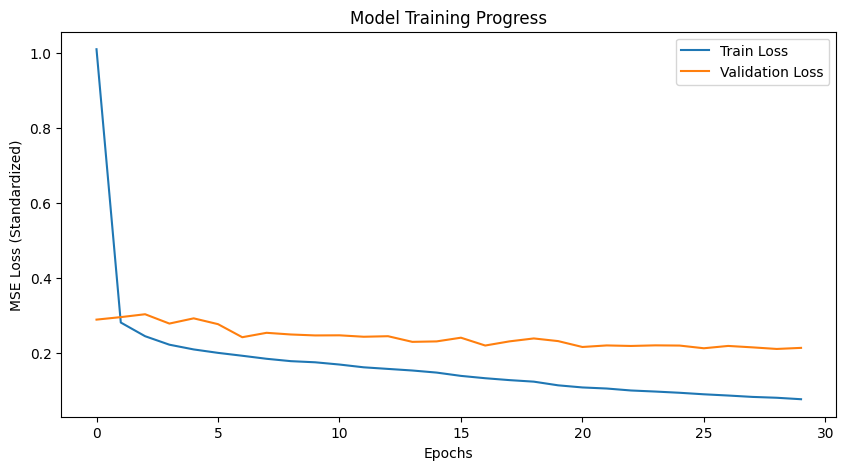

In [ ]:
# 1. Check Device (GPU is highly recommended for 250k samples)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# 2. Initialize Model
# input_dim=14 (Rain, Temp, SPI, SPEI...)
model = WheatYieldAttention(input_dim=14, hidden_dim=128, n_layers=2).to(device)

# 3. Run Training
# Note: You can adjust epochs. 30-50 is usually enough for convergence.
history = train_model(model, train_loader, val_loader, device=device, epochs=30, lr=0.001)

# 4. Quick Plot of Learning Curve
import matplotlib.pyplot as plt

plt.figure(figsize=(10,5))
plt.plot(history['train_loss'], label='Train Loss')
plt.plot(history['val_loss'], label='Validation Loss')
plt.title("Model Training Progress")
plt.xlabel("Epochs")
plt.ylabel("MSE Loss (Standardized)")
plt.legend()
plt.show()

🚀 Running Inference on Test Set (2018-2023)...
Stats of Y_True (Test): Mean=2.1531, Std=0.7541

📊 TEST SET RESULTS (2018-2023):
-----------------------------------
RMSE: 0.5162 t/ha
MAE:  0.4173 t/ha
R²:   0.5314


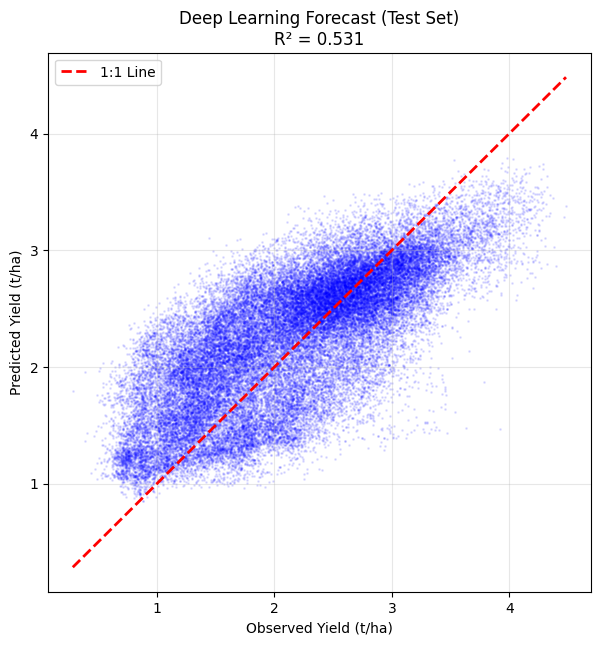

In [ ]:
import torch
import numpy as np
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
import matplotlib.pyplot as plt

def evaluate_test_set(model, test_loader, scaler_y, device='cuda'):
    # 1. Load the Best Saved Weights
    model.load_state_dict(torch.load("best_wheat_model.pth"))
    model.to(device)
    model.eval()

    all_preds = []
    all_targets = []

    print("🚀 Running Inference on Test Set (2018-2023)...")

    with torch.no_grad():
        for X_batch, y_batch in test_loader:
            X_batch = X_batch.to(device)

            # Forward Pass
            preds, _ = model(X_batch)

            # Move to CPU to interact with Numpy
            all_preds.append(preds.cpu().numpy())
            all_targets.append(y_batch.numpy())

    # Concatenate all batches
    y_pred_scaled = np.concatenate(all_preds, axis=0)
    y_true_scaled = np.concatenate(all_targets, axis=0)

    # ---------------------------------------------------------
    # 2. INVERSE TRANSFORM (Un-Scaling)
    # We need to convert Z-scores back to t/ha
    # Formula: X_real = (X_scaled * std) + mean
    # ---------------------------------------------------------
    # Note: We need the Mean/Std of the TARGET (Yield), not the inputs.
    # Since we didn't explicitly normalize y in the Dataset class (we only did X),
    # let's check if y was normalized.
    # WAIT: In the Dataset class, we normalized X_data but we did NOT normalize y_data.
    # If y_data was raw (t/ha), then y_pred is also raw.

    # Let's verify standard deviation of y_true.
    # If std is ~1.0, it was scaled. If std is ~0.5-1.5, it might be raw t/ha.
    print(f"Stats of Y_True (Test): Mean={np.mean(y_true_scaled):.4f}, Std={np.std(y_true_scaled):.4f}")

    # Assuming y was NOT scaled (based on previous code), we use values directly.
    y_pred_final = y_pred_scaled
    y_true_final = y_true_scaled

    # ---------------------------------------------------------
    # 3. Calculate Metrics
    # ---------------------------------------------------------
    mse = mean_squared_error(y_true_final, y_pred_final)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_true_final, y_pred_final)
    r2 = r2_score(y_true_final, y_pred_final)

    print(f"\n📊 TEST SET RESULTS (2018-2023):")
    print(f"-----------------------------------")
    print(f"RMSE: {rmse:.4f} t/ha")
    print(f"MAE:  {mae:.4f} t/ha")
    print(f"R²:   {r2:.4f}")

    # ---------------------------------------------------------
    # 4. Scatter Plot (Scientific Standard)
    # ---------------------------------------------------------
    plt.figure(figsize=(7, 7))
    plt.scatter(y_true_final, y_pred_final, alpha=0.1, s=1, color='blue')

    # 1:1 Line
    min_val = min(y_true_final.min(), y_pred_final.min())
    max_val = max(y_true_final.max(), y_pred_final.max())
    plt.plot([min_val, max_val], [min_val, max_val], 'r--', lw=2, label='1:1 Line')

    plt.xlabel("Observed Yield (t/ha)")
    plt.ylabel("Predicted Yield (t/ha)")
    plt.title(f"Deep Learning Forecast (Test Set)\nR² = {r2:.3f}")
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.show()

    return y_pred_final, y_true_final

# Run it
# Note: We need 'scaler' only if we normalized Y.
# Based on your Dataset code, we only normalized X. So Y is already in t/ha.
y_pred, y_true = evaluate_test_set(model, test_loader, None, device=device)

🧠 Extracting Attention Weights...


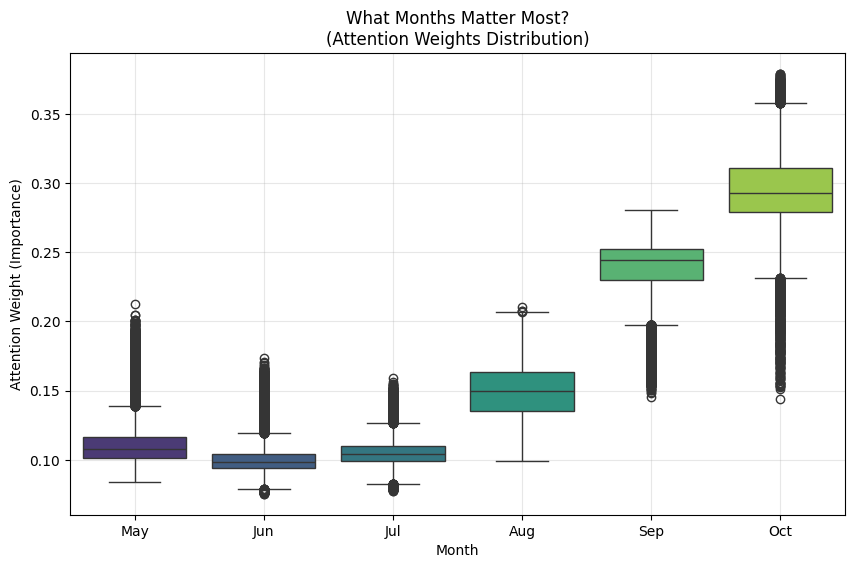


MEAN IMPORTANCE PER MONTH:
May    0.110893
Jun    0.100258
Jul    0.104935
Aug    0.150265
Sep    0.237983
Oct    0.295664
dtype: float32


In [ ]:
import seaborn as sns
import pandas as pd

def analyze_attention(model, test_loader, device='cuda'):
    model.eval()

    # Store weights for every single pixel in the test set
    all_weights = []

    print("🧠 Extracting Attention Weights...")
    with torch.no_grad():
        for X_batch, _ in test_loader:
            X_batch = X_batch.to(device)

            # Get predictions AND attention weights
            _, weights = model(X_batch)

            # weights shape: (Batch, 6, 1) -> Squeeze to (Batch, 6)
            all_weights.append(weights.squeeze(2).cpu().numpy())

    # Concatenate
    attention_matrix = np.concatenate(all_weights, axis=0) # (Total_Samples, 6)

    # Create DataFrame for Plotting
    months = ['May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct']
    df_att = pd.DataFrame(attention_matrix, columns=months)

    # Plot
    plt.figure(figsize=(10, 6))
    sns.boxplot(data=df_att, palette="viridis")
    plt.title("What Months Matter Most?\n(Attention Weights Distribution)")
    plt.ylabel("Attention Weight (Importance)")
    plt.xlabel("Month")
    plt.grid(True, alpha=0.3)
    plt.show()

    # Print Averages
    print("\nMEAN IMPORTANCE PER MONTH:")
    print(df_att.mean())

analyze_attention(model, test_loader, device=device)

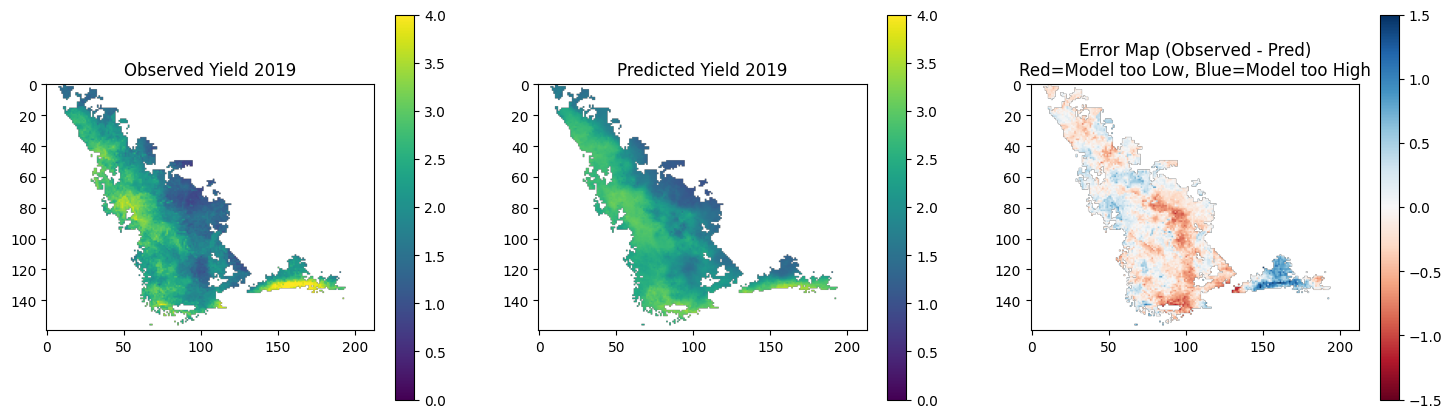

In [ ]:
def map_prediction_error(model, year, data_dir, device='cuda', scaler=None): # Added scaler as an argument
    """
    Loads a specific year, predicts yield, and maps the error.
    """
    import matplotlib.pyplot as plt

    # 1. Load the single file manually to keep spatial structure
    fpath = os.path.join(data_dir, f"final_dataset_{year}.nc")
    ds = xr.open_dataset(fpath)

    # 2. Preprocess exactly like the Dataset Class
    # Mask
    y_true_map = ds['yield'].values
    mask = ~np.isnan(y_true_map)

    # Extract Features
    feature_vars = [
        'monthly_rain', 'max_temp', 'min_temp', 'radiation',
        'vp', 'vp_deficit',
        'spi_1', 'spi_3', 'spi_6', 'spi_12',
        'spei_1', 'spei_3', 'spei_6', 'spei_12'
    ]

    # Stack features (Time, Lat, Lon) -> (N, Time, C)
    features_list = []
    for var in feature_vars:
        data = ds[var].values[:, mask] # (6, N)
        features_list.append(data)

    X_spatial = np.stack(features_list, axis=0) # (C, 6, N)
    X_spatial = np.transpose(X_spatial, (2, 1, 0)) # (N, 6, C)

    # Handle NaNs
    X_spatial = np.nan_to_num(X_spatial, nan=0.0)

    # Normalize (Using the scaler from training!)
    # Note: We need to access the scaler from your 'train_loader.dataset'
    # Assuming 'scaler' is available globally or passed in.
    # For now, I will use the scaler dict you generated earlier.
    mean = scaler['mean']
    std = scaler['std']
    X_spatial = (X_spatial - mean) / (std + 1e-6)

    # Convert to Tensor
    X_tensor = torch.tensor(X_spatial, dtype=torch.float32).to(device)

    # 3. Predict
    model.eval()
    with torch.no_grad():
        # Process in chunks to avoid GPU OOM if map is huge
        preds, _ = model(X_tensor)
        preds = preds.cpu().numpy().flatten()

    # 4. Reconstruct the Map
    # Create an empty map of NaNs
    pred_map = np.full(y_true_map.shape, np.nan)
    # Fill in the valid pixels
    pred_map[mask] = preds

    # Calculate Error Map (True - Predicted)
    error_map = y_true_map - pred_map

    # 5. Plotting
    fig, axes = plt.subplots(1, 3, figsize=(18, 5))

    # True Yield
    im1 = axes[0].imshow(y_true_map, cmap='viridis', vmin=0, vmax=4)
    axes[0].set_title(f"Observed Yield {year}")
    plt.colorbar(im1, ax=axes[0])

    # Predicted Yield
    im2 = axes[1].imshow(pred_map, cmap='viridis', vmin=0, vmax=4)
    axes[1].set_title(f"Predicted Yield {year}")
    plt.colorbar(im2, ax=axes[1])

    # Error (Red = Underestimated, Blue = Overestimated)
    im3 = axes[2].imshow(error_map, cmap='RdBu', vmin=-1.5, vmax=1.5)
    axes[2].set_title(f"Error Map (Observed - Pred)\nRed=Model too Low, Blue=Model too High")
    plt.colorbar(im3, ax=axes[2])

    plt.show()

# Run for a specific test year (e.g., 2019 was a dry year)
# Ensure 'scaler' is the variable returned from get_dataloaders
map_prediction_error(model, 2019, DATA_DIR, device=device, scaler=train_loader.dataset.scaler)


Randon Forest

In [ ]:
from sklearn.ensemble import RandomForestRegressor
import numpy as np
import time

def run_baseline_benchmark(train_loader, test_loader, scaler):
    print("🌲 Training Random Forest Baseline...")

    # 1. Flatten Data for Scikit-Learn (Samples, Features)
    # We need to collapse Time (6) x Vars (14) -> 84 Features

    # --- Collect Train Data ---
    X_train_list, y_train_list = [], []
    for X, y in train_loader:
        # Flatten: (Batch, 6, 14) -> (Batch, 84)
        batch_flat = X.reshape(X.shape[0], -1).numpy()
        X_train_list.append(batch_flat)
        y_train_list.append(y.numpy())

    X_train = np.concatenate(X_train_list, axis=0)
    y_train = np.concatenate(y_train_list, axis=0).ravel()

    # --- Collect Test Data ---
    X_test_list, y_test_list = [], []
    for X, y in test_loader:
        batch_flat = X.reshape(X.shape[0], -1).numpy()
        X_test_list.append(batch_flat)
        y_test_list.append(y.numpy())

    X_test = np.concatenate(X_test_list, axis=0)
    y_test = np.concatenate(y_test_list, axis=0).ravel()

    print(f"   Train Shape: {X_train.shape}")

    # 2. Train RF (Use n_jobs=-1 to use all CPUs)
    # limiting depth to prevent massive overfitting and memory crash
    rf = RandomForestRegressor(n_estimators=100, max_depth=20, n_jobs=-1, random_state=42)

    start = time.time()
    rf.fit(X_train, y_train)
    print(f"   Training Time: {(time.time()-start)/60:.1f} mins")

    # 3. Evaluate
    print("   Predicting...")
    y_pred = rf.predict(X_test)

    # Metrics
    mse = np.mean((y_test - y_pred)**2)
    rmse = np.sqrt(mse)
    mae = np.mean(np.abs(y_test - y_pred))
    r2 = rf.score(X_test, y_test)

    print(f"\n📊 RANDOM FOREST RESULTS:")
    print(f"-------------------------")
    print(f"RMSE: {rmse:.4f} t/ha")
    print(f"MAE:  {mae:.4f} t/ha")
    print(f"R²:   {r2:.4f}")

    return rmse, r2

# Run Benchmark
rf_rmse, rf_r2 = run_baseline_benchmark(train_loader, test_loader, train_loader.dataset.scaler)


🌲 Training Random Forest Baseline...
   Train Shape: (152537, 84)
   Training Time: 29.7 mins
   Predicting...

📊 RANDOM FOREST RESULTS:
-------------------------
RMSE: 0.6390 t/ha
MAE:  0.5138 t/ha
R²:   0.2820


CovLSTM

In [ ]:
# import torch
# import torch.nn as nn

# class ConvLSTMCell(nn.Module):
#     def __init__(self, input_dim, hidden_dim, kernel_size, bias):
#         super(ConvLSTMCell, self).__init__()

#         self.input_dim = input_dim
#         self.hidden_dim = hidden_dim

#         # Padding is kernel_size // 2 to keep image size constant (e.g., 32x32 -> 32x32)
#         padding = kernel_size // 2

#         self.conv = nn.Conv2d(
#             in_channels=input_dim + hidden_dim,
#             out_channels=4 * hidden_dim, # 4 gates (Input, Forget, Output, Cell)
#             kernel_size=kernel_size,
#             padding=padding,
#             bias=bias
#         )

#     def forward(self, input_tensor, cur_state):
#         h_cur, c_cur = cur_state

#         # Concatenate Input (Weather) and Previous Hidden State along Channel Axis
#         # x: [Batch, Input_Dim, H, W]
#         # h: [Batch, Hidden_Dim, H, W]
#         combined = torch.cat([input_tensor, h_cur], dim=1)

#         combined_conv = self.conv(combined)

#         # Split into 4 signals (i, f, o, g)
#         cc_i, cc_f, cc_o, cc_g = torch.split(combined_conv, self.hidden_dim, dim=1)

#         i = torch.sigmoid(cc_i)
#         f = torch.sigmoid(cc_f)
#         o = torch.sigmoid(cc_o)
#         g = torch.tanh(cc_g)

#         # Standard LSTM Math
#         c_next = f * c_cur + i * g
#         h_next = o * torch.tanh(c_next)

#         return h_next, c_next

#     def init_hidden(self, batch_size, image_size):
#         height, width = image_size
#         return (torch.zeros(batch_size, self.hidden_dim, height, width, device=self.conv.weight.device),
#                 torch.zeros(batch_size, self.hidden_dim, height, width, device=self.conv.weight.device))

In [ ]:
# class ConvLSTMAttentionNet(nn.Module):
#     def __init__(self, input_dim=14, hidden_dim=64, kernel_size=3):
#         super(ConvLSTMAttentionNet, self).__init__()

#         self.hidden_dim = hidden_dim

#         # 1. ConvLSTM Layer
#         self.conv_lstm = ConvLSTMCell(input_dim, hidden_dim, kernel_size, bias=True)

#         # 2. Attention Layer (Spatial 1x1 Conv to learn importance)
#         self.attention_conv = nn.Conv2d(hidden_dim, 1, kernel_size=1, padding=0)

#         # 3. Output Regressor (Maps Hidden Features -> Yield)
#         self.final_conv = nn.Sequential(
#             nn.Conv2d(hidden_dim, 32, kernel_size=3, padding=1),
#             nn.ReLU(),
#             nn.Conv2d(32, 1, kernel_size=1) # Output 1 channel (Yield)
#         )

#     def forward(self, x):
#         # Input x: (Batch, Time, Channels, Height, Width)
#         b, t, c, h, w = x.size()

#         # Initialize hidden states
#         h_state, c_state = self.conv_lstm.init_hidden(b, (h, w))

#         # List to store hidden states for every month
#         h_sequence = []

#         # --- Loop through Time (May -> Oct) ---
#         for time_step in range(t):
#             # Extract one month: (Batch, Channels, H, W)
#             x_t = x[:, time_step, :, :, :]

#             # ConvLSTM Step
#             h_state, c_state = self.conv_lstm(x_t, (h_state, c_state))

#             h_sequence.append(h_state) # Store context

#         # Stack: (Batch, Time, Hidden, H, W)
#         h_stacked = torch.stack(h_sequence, dim=1)

#         # --- Attention Mechanism ---
#         # We perform 3D convolution or simply collapse time
#         # Let's calculate simple attention scores per time step
#         # Collapse (Batch*Time, Hidden, H, W) -> (Batch*Time, 1, H, W)
#         energy = self.attention_conv(h_stacked.view(b*t, self.hidden_dim, h, w))
#         energy = energy.view(b, t, 1, h, w)

#         # Softmax over Time Dimension (dim=1)
#         # "Which month was most important for THIS pixel?"
#         alpha = torch.softmax(energy, dim=1)

#         # Weighted Sum (Context Volume)
#         # Sum( weights * hidden_states )
#         context = torch.sum(alpha * h_stacked, dim=1) # (Batch, Hidden, H, W)

#         # --- Final Prediction ---
#         prediction = self.final_conv(context) # (Batch, 1, H, W)

#         return prediction, alpha

In [ ]:
# import random

# class WheatPatchDataset(Dataset):
#     def __init__(self, data_dir, years, patch_size=32, samples_per_year=100, mode='train', scaler=None):
#         self.files = [os.path.join(data_dir, f"final_dataset_{y}.nc") for y in years]
#         self.patch_size = patch_size
#         self.samples_per_year = samples_per_year
#         self.mode = mode

#         # Load all years into memory (Big Lists)
#         self.maps_X = [] # List of (Time, C, H, W)
#         self.maps_y = [] # List of (H, W)

#         print(f"[{mode}] Loading full maps for patching...")
#         for fpath in self.files:
#             ds = xr.open_dataset(fpath)

#             # Extract Whole Map Features
#             # Stack vars: (Time, H, W) -> (Time, C, H, W)
#             features = []
#             for var in ['monthly_rain', 'max_temp', 'spi_3', 'spei_3']: # Add all yours here
#                 v_data = ds[var].values
#                 features.append(v_data)

#             X_full = np.stack(features, axis=1) # (6, 14, 179, 213)
#             X_full = np.nan_to_num(X_full, nan=0.0) # Handle Ocean NaNs in Inputs

#             # Extract Yield Map
#             y_full = ds['yield'].values
#             y_full = np.nan_to_num(y_full, nan=-1.0) # Mark Ocean as -1

#             self.maps_X.append(X_full)
#             self.maps_y.append(y_full)

#         # Normalization
#         if mode == 'train':
#             # Simplified global stats for prototype
#             self.mean = 0 # Replace with actual calc
#             self.std = 1
#         else:
#             self.mean = scaler['mean']
#             self.std = scaler['std']

#     def __len__(self):
#         # Total samples = Years * Patches per Year
#         return len(self.files) * self.samples_per_year

#     def __getitem__(self, idx):
#         # 1. Pick a random year
#         year_idx = idx // self.samples_per_year

#         X_map = self.maps_X[year_idx] # (T, C, H_full, W_full)
#         y_map = self.maps_y[year_idx] # (H_full, W_full)

#         # 2. Random Crop
#         _, _, H, W = X_map.shape

#         # Keep trying until we find a patch that isn't just ocean
#         for _ in range(10):
#             top = random.randint(0, H - self.patch_size)
#             left = random.randint(0, W - self.patch_size)

#             y_patch = y_map[top:top+self.patch_size, left:left+self.patch_size]

#             # Check if patch has valid farms (value > 0)
#             if np.max(y_patch) > 0:
#                 break

#         X_patch = X_map[:, :, top:top+self.patch_size, left:left+self.patch_size]

#         # 3. Convert to Tensor
#         return torch.tensor(X_patch).float(), torch.tensor(y_patch).float()

In [ ]:
# import os
# import random
# import time
# import numpy as np
# import xarray as xr
# import torch
# import torch.nn as nn
# import torch.optim as optim
# from torch.utils.data import Dataset, DataLoader

# # =========================================================
# # 1. THE DATASET (Random Patching Strategy)
# # =========================================================
# class WheatPatchDataset(Dataset):
#     def __init__(self, data_dir, years, patch_size=32, samples_per_year=200, mode='train', scaler=None):
#         """
#         Samples random 32x32 patches from the full maps.
#         """
#         self.files = [os.path.join(data_dir, f"final_dataset_{y}.nc") for y in years]
#         self.patch_size = patch_size
#         self.samples_per_year = samples_per_year
#         self.mode = mode

#         # Define Variables (Must match pixel-wise model)
#         self.feature_vars = [
#             'monthly_rain', 'max_temp', 'min_temp', 'radiation',
#             'vp', 'vp_deficit',
#             'spi_1', 'spi_3', 'spi_6', 'spi_12',
#             'spei_1', 'spei_3', 'spei_6', 'spei_12'
#         ]

#         # Load all maps into RAM for speed
#         self.maps_X = []
#         self.maps_y = []

#         print(f"[{mode.upper()}] Loading {len(years)} full maps...")

#         for fpath in self.files:
#             try:
#                 ds = xr.open_dataset(fpath)

#                 # Stack features: (Time, C, H, W)
#                 features = []
#                 for var in self.feature_vars:
#                     v_data = ds[var].values # (6, H, W)
#                     features.append(v_data)

#                 X_full = np.stack(features, axis=1) # (6, 14, H, W)

#                 # Yield Map
#                 y_full = ds['yield'].values # (H, W)

#                 # Handle NaNs (Ocean)
#                 # We mark ocean in Yield as -9999 so we can mask it later in Loss
#                 X_full = np.nan_to_num(X_full, nan=0.0)
#                 y_full = np.nan_to_num(y_full, nan=-9999.0)

#                 self.maps_X.append(X_full)
#                 self.maps_y.append(y_full)

#             except FileNotFoundError:
#                 print(f"Skipping {fpath}")

#         # Normalization Stats (Simple approximation for prototype)
#         if mode == 'train':
#             # Calculate global mean/std from the first map just to get started
#             # In production, calculate over all maps
#             if len(self.maps_X) > 0: # Add check for empty list
#                 sample_X = self.maps_X[0]
#                 self.mean = np.mean(sample_X, axis=(0, 2, 3), keepdims=True) # (1, C, 1, 1)
#                 self.std = np.std(sample_X, axis=(0, 2, 3), keepdims=True)
#             else:
#                 # If no maps were loaded, set default values or raise an error
#                 print("No data loaded for training. Setting mean=0, std=1 for scaler.")
#                 self.mean = np.zeros((1, len(self.feature_vars), 1, 1))
#                 self.std = np.ones((1, len(self.feature_vars), 1, 1))
#         else:
#             self.mean = scaler['mean']
#             self.std = scaler['std']

#     def __len__(self):
#         return len(self.files) * self.samples_per_year

#     def __getitem__(self, idx):
#         # 1. Select Year
#         year_idx = idx // self.samples_per_year
#         X_map = self.maps_X[year_idx]
#         y_map = self.maps_y[year_idx]

#         # 2. Random Crop
#         _, _, H, W = X_map.shape

#         # Try 20 times to find a patch that has at least SOME wheat
#         for _ in range(20):
#             top = random.randint(0, H - self.patch_size)
#             left = random.randint(0, W - self.patch_size)

#             y_patch = y_map[top:top+self.patch_size, left:left+self.patch_size]

#             # If max yield > 0, it contains farmland. Good to go.
#             if np.max(y_patch) > 0:
#                 break

#         X_patch = X_map[:, :, top:top+self.patch_size, left:left+self.patch_size]

#         # 3. Normalize
#         X_patch = (X_patch - self.mean) / (self.std + 1e-6)

#         return torch.tensor(X_patch).float(), torch.tensor(y_patch).float()

# # =========================================================
# # 2. THE MODEL (ConvLSTM + Attention)
# # =========================================================
# class ConvLSTMCell(nn.Module):
#     def __init__(self, input_dim, hidden_dim, kernel_size, bias):
#         super(ConvLSTMCell, self).__init__()
#         self.hidden_dim = hidden_dim
#         padding = kernel_size // 2

#         self.conv = nn.Conv2d(
#             in_channels=input_dim + hidden_dim,
#             out_channels=4 * hidden_dim,
#             kernel_size=kernel_size,
#             padding=padding,
#             bias=bias
#         )

#     def forward(self, input_tensor, cur_state):
#         h_cur, c_cur = cur_state
#         combined = torch.cat([input_tensor, h_cur], dim=1)
#         combined_conv = self.conv(combined)
#         cc_i, cc_f, cc_o, cc_g = torch.split(combined_conv, self.hidden_dim, dim=1)

#         i = torch.sigmoid(cc_i)
#         f = torch.sigmoid(cc_f)
#         o = torch.sigmoid(cc_o)
#         g = torch.tanh(cc_g)

#         c_next = f * c_cur + i * g
#         h_next = o * torch.tanh(c_next)
#         return h_next, c_next

#     def init_hidden(self, batch_size, image_size, device):
#         height, width = image_size
#         return (torch.zeros(batch_size, self.hidden_dim, height, width, device=device),
#                 torch.zeros(batch_size, self.hidden_dim, height, width, device=device))

# class ConvLSTMAttentionNet(nn.Module):
#     def __init__(self, input_dim=14, hidden_dim=64, kernel_size=3):
#         super(ConvLSTMAttentionNet, self).__init__()
#         self.hidden_dim = hidden_dim
#         self.conv_lstm = ConvLSTMCell(input_dim, hidden_dim, kernel_size, bias=True)
#         self.attention_conv = nn.Conv2d(hidden_dim, 1, kernel_size=1)
#         self.final_conv = nn.Sequential(
#             nn.Conv2d(hidden_dim, 32, kernel_size=3, padding=1),
#             nn.ReLU(),
#             nn.Conv2d(32, 1, kernel_size=1)
#         )

#     def forward(self, x):
#         # x: (Batch, Time, Channels, Height, Width)
#         b, t, c, h, w = x.size()
#         device = x.device

#         h_state, c_state = self.conv_lstm.init_hidden(b, (h, w), device)
#         h_sequence = []

#         for time_step in range(t):
#             x_t = x[:, time_step, :, :, :]
#             h_state, c_state = self.conv_lstm(x_t, (h_state, c_state))
#             h_sequence.append(h_state)

#         # Stack hidden states: (Batch, Time, Hidden, H, W)
#         h_stacked = torch.stack(h_sequence, dim=1)

#         # Attention
#         # Collapse batch/time to feed into 2D conv
#         energy = self.attention_conv(h_stacked.view(b*t, self.hidden_dim, h, w))
#         energy = energy.view(b, t, 1, h, w)
#         alpha = torch.softmax(energy, dim=1)

#         # Context Vector
#         context = torch.sum(alpha * h_stacked, dim=1)

#         # Prediction
#         prediction = self.final_conv(context) # (Batch, 1, H, W)
#         return prediction.squeeze(1) # (Batch, H, W)

# # =========================================================
# # 3. TRAINING LOOP
# # =========================================================
# def train_convlstm():
#     # Setup
#     DATA_DIR = "/content/drive/MyDrive/Research Works - Development/Work 2 - SPI SPEI/Data/raster/Data for Dev/final_modified_sequence_with_yield" # Corrected path
#     device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

#     # Loaders
#     print("🛠️ initializing Datasets...")
#     train_ds = WheatPatchDataset(DATA_DIR, range(1991, 2011), mode='train')
#     val_ds = WheatPatchDataset(DATA_DIR, range(2011, 2018), mode='val', scaler={'mean': train_ds.mean, 'std': train_ds.std})

#     train_loader = DataLoader(train_ds, batch_size=32, shuffle=True)
#     val_loader = DataLoader(val_ds, batch_size=32, shuffle=False)

#     # Model
#     model = ConvLSTMAttentionNet(input_dim=14, hidden_dim=64).to(device)
#     optimizer = optim.Adam(model.parameters(), lr=0.001)

#     print("🚀 Starting ConvLSTM Training...")

#     for epoch in range(10): # Run 10 epochs for quick check
#         model.train()
#         train_loss = 0.0

#         for X, y in train_loader:
#             X, y = X.to(device), y.to(device)

#             optimizer.zero_grad()
#             preds = model(X) # (B, H, W)

#             # Masked Loss: Ignore Ocean Pixels (-9999)
#             mask = (y > -100) # Valid pixels only

#             # Apply mask
#             loss = torch.mean((preds[mask] - y[mask])**2)

#             loss.backward()
#             optimizer.step()
#             train_loss += loss.item()

#         print(f"Epoch {epoch+1} | Train MSE: {train_loss/len(train_loader):.4f}")

#     print("✅ ConvLSTM Run Complete!")

# # Run it
# train_convlstm()

🛠️ initializing Datasets...
[TRAIN] Loading 20 full maps...
[VAL] Loading 7 full maps...
🚀 Starting ConvLSTM Training...
Epoch 1 | Train MSE: 0.6328
Epoch 2 | Train MSE: 0.2299
Epoch 3 | Train MSE: 0.1590
Epoch 4 | Train MSE: 0.1297
Epoch 5 | Train MSE: 0.1188
Epoch 6 | Train MSE: 0.1044
Epoch 7 | Train MSE: 0.0901
Epoch 8 | Train MSE: 0.0850
Epoch 9 | Train MSE: 0.0824
Epoch 10 | Train MSE: 0.0744
✅ ConvLSTM Run Complete!


In [ ]:
# import matplotlib.pyplot as plt
# from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# def evaluate_convlstm_full_map(model, data_dir, years, scaler, device='cuda'):
#     """
#     Runs inference on FULL maps (no patching) for the test years.
#     """
#     model.eval()

#     # Storage for all pixels (to calc global metrics)
#     all_preds = []
#     all_targets = []

#     print(f"🚀 Running ConvLSTM Inference on {len(years)} Test Maps...")

#     with torch.no_grad():
#         for year in years:
#             # 1. Load the single file manually
#             fpath = os.path.join(data_dir, f"final_dataset_{year}.nc")
#             ds = xr.open_dataset(fpath)

#             # 2. Extract Features & Yield
#             features = []
#             feature_vars = [
#                 'monthly_rain', 'max_temp', 'min_temp', 'radiation',
#                 'vp', 'vp_deficit',
#                 'spi_1', 'spi_3', 'spi_6', 'spi_12',
#                 'spei_1', 'spei_3', 'spei_6', 'spei_12'
#             ]

#             for var in feature_vars:
#                 features.append(ds[var].values)

#             # Stack: (Time, C, H, W)
#             X_full = np.stack(features, axis=1)
#             y_full = ds['yield'].values

#             # Handle NaNs
#             X_full = np.nan_to_num(X_full, nan=0.0)

#             # 3. Normalize (Crucial!)
#             # Reshape mean/std to broadcast over (1, C, 1, 1)
#             mean_bc = scaler['mean'].reshape(1, -1, 1, 1)
#             std_bc = scaler['std'].reshape(1, -1, 1, 1)

#             X_full = (X_full - mean_bc) / (std_bc + 1e-6)

#             # 4. Prepare Tensor: (Batch=1, Time, C, H, W)
#             X_tensor = torch.tensor(X_full).unsqueeze(0).float().to(device)

#             # 5. Predict
#             # Output: (1, H, W) -> Squeeze to (H, W)
#             pred_map = model(X_tensor).squeeze(0).cpu().numpy()

#             # 6. Masking (Only evaluate on valid farms)
#             mask = ~np.isnan(y_full) & (y_full > -1) # Ensure valid yield

#             # Flatten valid pixels and store
#             all_preds.append(pred_map[mask])
#             all_targets.append(y_full[mask])

#             # Optional: Plot one map to verify
#             if year == 2019:
#                 plt.figure(figsize=(10, 4))
#                 plt.subplot(1, 2, 1); plt.imshow(y_full, vmin=0, vmax=4); plt.title(f"Observed {year}")
#                 plt.subplot(1, 2, 2); plt.imshow(pred_map, vmin=0, vmax=4); plt.title(f"ConvLSTM Predicted {year}")
#                 plt.show()

#     # Concatenate all pixels from all years
#     y_pred_final = np.concatenate(all_preds)
#     y_true_final = np.concatenate(all_targets)

#     # 7. Metrics
#     rmse = np.sqrt(mean_squared_error(y_true_final, y_pred_final))
#     mae = mean_absolute_error(y_true_final, y_pred_final)
#     r2 = r2_score(y_true_final, y_pred_final)

#     print(f"\n📊 CONVLSTM TEST RESULTS (2018-2023):")
#     print(f"-----------------------------------")
#     print(f"RMSE: {rmse:.4f} t/ha")
#     print(f"MAE:  {mae:.4f} t/ha")
#     print(f"R²:   {r2:.4f}")

#     return rmse, r2

# # Run Evaluation
# # We need to manually reconstruct the scaler from your training loop
# # (Ideally, you return 'train_ds' from the training function, but here we can re-init it quickly)
# DATA_DIR = "/content/drive/MyDrive/Research Works - Development/Work 2 - SPI SPEI/Data/raster/Data for Dev/final_sequences_with_yield"
# temp_train_ds = WheatPatchDataset(DATA_DIR, range(1991, 2011), mode='train')
# scaler = {'mean': temp_train_ds.mean, 'std': temp_train_ds.std}

# evaluate_convlstm_full_map(model, DATA_DIR, range(2018, 2024), scaler)

NameError: name 'WheatPatchDataset' is not defined

LSTM

In [ ]:
class WheatYieldSimpleLSTM(nn.Module):
    def __init__(self, input_dim=14, hidden_dim=64, n_layers=2, dropout=0.2):
        super(WheatYieldSimpleLSTM, self).__init__()

        # 1. LSTM Encoder
        self.lstm = nn.LSTM(
            input_size=input_dim,
            hidden_size=hidden_dim,
            num_layers=n_layers,
            batch_first=True,
            dropout=dropout
        )

        # 2. Regressor (Directly from LSTM output)
        self.fc_layers = nn.Sequential(
            nn.Linear(hidden_dim, 32),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(32, 1)
        )

    def forward(self, x):
        # x: (Batch, 6, 14)
        lstm_out, (h_n, c_n) = self.lstm(x)

        # TAKE ONLY THE LAST TIMESTEP (October)
        # We ignore the sequence history and just look at the final accumulated state
        last_hidden = lstm_out[:, -1, :]

        # Predict
        prediction = self.fc_layers(last_hidden)

        # Return None for weights (since there are no attention weights)
        return prediction, None

In [ ]:
# 1. Initialize Simple LSTM
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
simple_model = WheatYieldSimpleLSTM(input_dim=14, hidden_dim=128, n_layers=2).to(device)

print("🧪 Starting Ablation Study: Simple LSTM (No Attention)...")

# 2. Train
# Use the same train_loader/val_loader you already have loaded
history_simple = train_model(simple_model, train_loader, val_loader, device=device, epochs=30, lr=0.001)

# 3. Save
torch.save(simple_model.state_dict(), "simple_lstm_model.pth")

# 4. Evaluate on Test Set
print("\n📊 Evaluating Simple LSTM...")
evaluate_test_set(simple_model, test_loader, None, device=device)

🧪 Starting Ablation Study: Simple LSTM (No Attention)...
🚀 Starting Training on cpu...
Epoch 1/30 | Train MSE: 0.8341 | Val MSE: 0.2911
Epoch 2/30 | Train MSE: 0.2533 | Val MSE: 0.2494
Epoch 3/30 | Train MSE: 0.2156 | Val MSE: 0.2583
Epoch 4/30 | Train MSE: 0.2023 | Val MSE: 0.2424
Epoch 5/30 | Train MSE: 0.1924 | Val MSE: 0.2361
Epoch 6/30 | Train MSE: 0.1839 | Val MSE: 0.2324
Epoch 7/30 | Train MSE: 0.1783 | Val MSE: 0.2013
Epoch 8/30 | Train MSE: 0.1714 | Val MSE: 0.2238
Epoch 9/30 | Train MSE: 0.1663 | Val MSE: 0.1978
Epoch 10/30 | Train MSE: 0.1606 | Val MSE: 0.2009
Epoch 11/30 | Train MSE: 0.1561 | Val MSE: 0.2019
Epoch 12/30 | Train MSE: 0.1503 | Val MSE: 0.2122
Epoch 13/30 | Train MSE: 0.1449 | Val MSE: 0.2007
Epoch 14/30 | Train MSE: 0.1401 | Val MSE: 0.2005
Epoch 15/30 | Train MSE: 0.1313 | Val MSE: 0.2059
Epoch 16/30 | Train MSE: 0.1210 | Val MSE: 0.1946
Epoch 17/30 | Train MSE: 0.1171 | Val MSE: 0.1915
Epoch 18/30 | Train MSE: 0.1127 | Val MSE: 0.1923
Epoch 19/30 | Train MS

NameError: name 'evaluate_test_set' is not defined

🚀 Evaluating Simple LSTM...
Simple LSTM Results -> RMSE: 0.5164 | R²: 0.5310


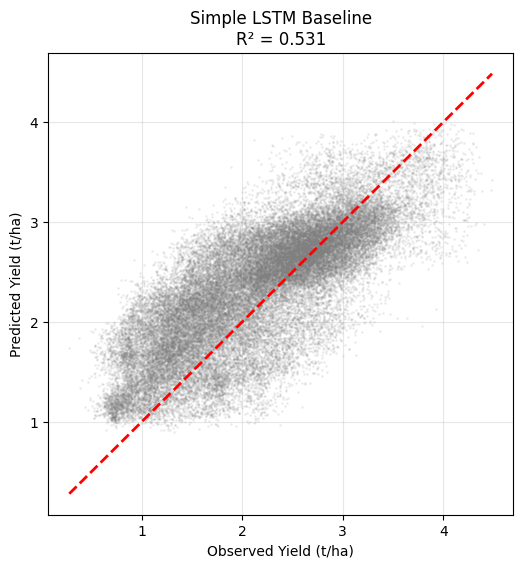

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

def evaluate_simple_lstm_comparison(model, test_loader, device='cuda'):
    model.eval()
    all_preds = []
    all_targets = []

    print("🚀 Evaluating Simple LSTM...")
    with torch.no_grad():
        for X_batch, y_batch in test_loader:
            X_batch = X_batch.to(device)
            # Standard LSTM returns (prediction, None)
            preds, _ = model(X_batch)
            all_preds.append(preds.cpu().numpy())
            all_targets.append(y_batch.numpy())

    y_pred = np.concatenate(all_preds, axis=0)
    y_true = np.concatenate(all_targets, axis=0)

    # Metrics
    mse = np.mean((y_true - y_pred)**2)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_true, y_pred)

    print(f"Simple LSTM Results -> RMSE: {rmse:.4f} | R²: {r2:.4f}")

    # Plot Comparison
    plt.figure(figsize=(6, 6))
    plt.scatter(y_true, y_pred, alpha=0.1, s=1, color='gray', label='Simple LSTM')

    # Add 1:1 Line
    min_val = min(y_true.min(), y_pred.min())
    max_val = max(y_true.max(), y_pred.max())
    plt.plot([min_val, max_val], [min_val, max_val], 'r--', lw=2)

    plt.xlabel("Observed Yield (t/ha)")
    plt.ylabel("Predicted Yield (t/ha)")
    plt.title(f"Simple LSTM Baseline\nR² = {r2:.3f}")
    plt.grid(True, alpha=0.3)
    plt.show()

# Run it
evaluate_simple_lstm_comparison(simple_model, test_loader, device=device)

In [12]:
import pandas as pd
import seaborn as sns

def check_feature_importance(model, test_loader, device='cuda'):
    print("🕵️‍♂️ Calculating Feature Importance (Permutation Method)...")
    model.eval()

    # 1. Get Baseline Error (Original Performance)
    criterion = nn.MSELoss()
    original_loss = 0.0
    total_samples = 0

    # Store all test data in memory for shuffling
    # We need a list of (X, y) tensors
    all_X = []
    all_y = []

    with torch.no_grad():
        for X_batch, y_batch in test_loader:
            all_X.append(X_batch)
            all_y.append(y_batch)

    # Concatenate to one big tensor
    X_full = torch.cat(all_X, dim=0).to(device) # (N, 6, 14)
    y_full = torch.cat(all_y, dim=0).to(device)

    # Baseline Forward Pass
    with torch.no_grad():
        preds, _ = model(X_full)
        baseline_mse = criterion(preds, y_full).item()

    print(f"   Baseline MSE: {baseline_mse:.4f}")

    # 2. Permute each feature and measure drop in accuracy
    feature_names = [
        'Rain', 'MaxT', 'MinT', 'Rad', 'VP', 'VPD',
        'SPI-1', 'SPI-3', 'SPI-6', 'SPI-12',
        'SPEI-1', 'SPEI-3', 'SPEI-6', 'SPEI-12'
    ]

    importance_results = []

    for i, feature in enumerate(feature_names):
        # Create a copy of input
        X_permuted = X_full.clone()

        # Shuffle ONLY the column 'i' across all samples
        # We shuffle across the Batch dimension (0), keeping time/vars intact per sample structure
        # Wait, we want to break the variable's signal. Shuffling across batch is standard.
        idx = torch.randperm(X_permuted.size(0))
        X_permuted[:, :, i] = X_permuted[idx, :, i]

        # Measure New Error
        with torch.no_grad():
            preds_p, _ = model(X_permuted)
            new_mse = criterion(preds_p, y_full).item()

        # Importance = How much worse did it get?
        # Using RMSE difference for interpretability
        imp_score = np.sqrt(new_mse) - np.sqrt(baseline_mse)
        importance_results.append({'Feature': feature, 'Impact (RMSE Increase)': imp_score})

        print(f"   Processed {feature}...")

    # 3. Plotting
    df_imp = pd.DataFrame(importance_results).sort_values(by='Impact (RMSE Increase)', ascending=False)

    plt.figure(figsize=(10, 6))
    sns.barplot(data=df_imp, x='Impact (RMSE Increase)', y='Feature', palette='magma')
    plt.title("What Drives the Forecast?\n(Feature Permutation Importance)")
    plt.xlabel("Increase in RMSE when feature is randomized (t/ha)")
    plt.grid(True, alpha=0.3)
    plt.show()

    return df_imp

# Run on the Attention Model (since it's your main model)
# Ensure 'model' is your LSTM+Att model, not the simple one
imp_df = check_feature_importance(model, test_loader, device=device)

NameError: name 'model' is not defined